# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

##  Predict the Next Day's High and Low
In the previous notebooks, we have covered how to import data, create data indicators and fit our data using the `LinearRegression` function. We also learned how to predict the movement of Gold ETF (GLD). The same method can be applied to  any other stock you wish to analyse by following the flowchart below. 
![image.png](https://d2a032ejo53cab.cloudfront.net/Glossary/CWrXkoK0/Predicting-high-and-low-new.drawio.png)

In this notebook, you will learn how to predict the next day's High and Low prices. We will implement a linear regression model on Gold ETF (GLD) that will predict the Day's High and Day's Low given its Day's Open, High, Low and other defined indicators. We will also plot the predicted vs actual High and Low prices. The key steps are:
1. [Import Libraries](#import)
2. [Import the Data](#data)
3. [Predict the High, Low Prices](#prediction)
4. [Plot Predicted vs Actual](#plot)

<a id='lib'></a>
## Import Libraries

We will import `pandas` and `numpy` for data manipulation and analysis. 

In [1]:
# Data manipulation
import warnings
import numpy as np
import pandas as pd

# Import Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# To ignore unwanted warnings
warnings.filterwarnings("ignore")

<a id='data'></a>
## Import the Data

We will import `gold_prices_linear_regression.csv` as `X_test`. We will also import the `yU_test` and `yD_test` datasets. This data was prepared in the previous section and can be downloaded from the downloadable zip folder in the last section of this course.

In [2]:
# Define the path for the data files
path = "../data_modules/"

# Read the data
X_test = pd.read_csv(
    path + "gold_prices_linear_regression.csv", index_col=0, parse_dates=True)
yU_test = pd.read_csv(path + "gold_prices_yU_test.csv",
                      index_col=0, parse_dates=True)
yD_test = pd.read_csv(path + "gold_prices_yD_test.csv",
                      index_col=0, parse_dates=True)

# Print X_test dataframe
X_test.head()

,Open,S_3,S_15,S_60,OD,OL,Corr,yU_predict,yD_predict
Date,,,,,,,,,
2018-03-13,125.669998,125.500000,125.664000,125.086834,0.629997,-0.129997,-0.324542,0.523085,0.557055
2018-03-14,125.489998,125.620000,125.633333,125.197000,-0.180000,0.290001,-0.250944,0.511956,0.558256
2018-03-15,125.120003,125.673332,125.635999,125.309834,-0.369995,0.579994,-0.109243,0.515335,0.546490
2018-03-16,124.839996,125.459999,125.542666,125.405167,-0.280007,0.060006,-0.183366,0.536250,0.533332
2018-03-19,124.570000,125.066666,125.439999,125.486334,-0.269996,0.029998,-0.203914,0.529188,0.534579


<a id='prediction'></a>
## Predict the High, Low Prices
We will predict the High and Low prices using the predicted values from the previous section. 

Since the upward and downward deviation can not be negative. So, we replace negative values with zero.

In [3]:
# Assign zero to all the negative predicted values to take into account real life conditions
X_test.loc[X_test['yU_predict'] < 0, 'yU_predict'] = 0
X_test.loc[X_test['yD_predict'] < 0, 'yD_predict'] = 0

We will use the predicted upside deviation values to calculate the High price and the predicted downside deviation values to calculate the Low price.

In [4]:
# Add open values in ['yU_predict'] to get the predicted High column
X_test['P_H'] = X_test['Open']+X_test['yU_predict']

# Subtract ['yD_predict'] values in open to get the predicted Low column.
X_test['P_L'] = X_test['Open']-X_test['yD_predict']

# Print tail of X_test dataframe
X_test.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr,yU_predict,yD_predict,P_H,P_L
Date,,,,,,,,,,,
2019-05-08,121.540001,120.890000,120.606668,122.611834,0.520004,-0.330002,-0.221595,0.501053,0.533787,122.041054,121.006214
2019-05-09,120.959999,120.976667,120.633335,122.567001,-0.580002,-0.049995,-0.290695,0.508194,0.526315,121.468193,120.433684
2019-05-10,121.410004,121.106667,120.694668,122.522667,0.450005,-0.210007,-0.280418,0.512847,0.528816,121.922851,120.881188
2019-05-13,122.629997,121.180000,120.765334,122.490334,1.219993,-1.199997,0.078028,0.504600,0.530648,123.134597,122.099349
2019-05-14,122.599998,121.766665,120.918667,122.467167,-0.029999,0.070000,0.365089,0.473075,0.538222,123.073073,122.061776


<a id='plot'></a>
## Plot Predicted vs Actual
Let us plot our predicted High and Low values along with the actual High and Low values to visualise our results. 

Before we can plot our values, we need to find the actual High and Low prices with the help of the `yU_test` and `yD_test` datasets. 

In [5]:
# Add open values in ['Std_U'] to get the actual High column
X_test['A_H'] = X_test['Open']+yU_test['Std_U']

# Subtract ['Std_D'] values in open to get the actual Low column.
X_test['A_L'] = X_test['Open']-yD_test['Std_D']

Now we can plot the predicted vs actual High prices for GLD. 

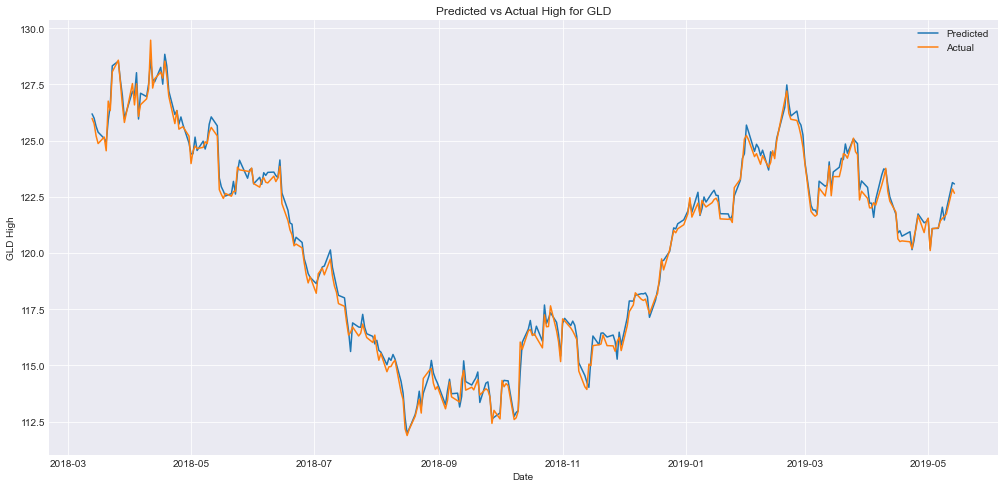

In [6]:
fig, ax = plt.subplots(figsize=(17, 8))
plt.plot(X_test['P_H'], label="Predicted")
plt.plot(X_test['A_H'], label="Actual")
plt.xlabel("Date")
plt.ylabel("GLD High")
plt.title("Predicted vs Actual High for GLD")
plt.legend()

Similarly, we can plot the predicted vs actual Low prices for GLD.

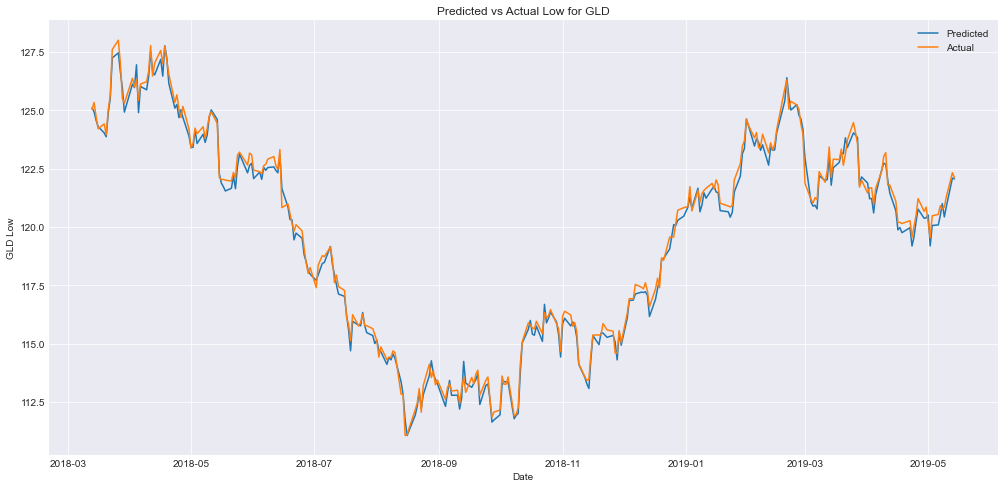

In [7]:
fig, ax = plt.subplots(figsize=(17, 8))
plt.plot(X_test['P_L'], label="Predicted")
plt.plot(X_test['A_L'], label="Actual")
plt.xlabel("Date")
plt.ylabel("GLD Low")
plt.title("Predicted vs Actual Low for GLD")
plt.legend()

## Conclusion
In this notebook, we have predicted the High and Low values represented by `P_H` and `P_L`, respectively. We also plotted the actual vs predicted High and Low prices for GLD. The next notebook, we will generate trading signals using the predicted Highs and Lows. We will also calculate the strategy returns and generate the performance statistics. <br><br>